In [25]:
import pandas as pd 
import pickle5 as pickle
import spacy
import re
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import preprocessing
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.graphics.gofplots import qqplot


In [30]:
#### Functions

#helper for inf and nan
def check_inf_nan(df,field_name):
    if (df[field_name].isin([np.nan, np.inf, -np.inf]).sum())==0:
        print("Dataset is clean")
    else:
        df[field_name].replace([np.inf, -np.inf], np.nan, inplace=True)  
        df[field_name].fillna(df[field_name].mean(), inplace=True)
        return df

#data tester
def test_data(df):
    testdata = pd.get_dummies(data,columns=['Na_sprzedaż_przez', 'Rodzaj_nieruchomosci','Liczba_pokoi', 'Liczba_łazienek', 'Parking', 'dzielnica','poziom_atrakcyjności'])
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_squared_error, make_scorer
    scoring='f1_macro'

    y = testdata['cena_za_metr']
    X = testdata.drop(['cena_za_metr','lokalizacja', 'lokalizacja_1','opis','opis_clean',], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
    scores = cross_val_score(LinearRegression(), X_train, y_train, cv=5)
    print(list(scores))
    print()
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

    print("========================")
    y = testdata['cena_za_metr']
    X = testdata.drop(['cena_za_metr','lokalizacja', 'lokalizacja_1','opis','opis_clean',], axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=17)
    scores = cross_val_score(LinearRegression(), X_train, y_train, scoring=make_scorer(mean_squared_error), cv=5)
    print(list(scores))
    print()
    print("Mean square error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    
#plots
    
def plot_wrapper(df):
    Box_plots(df)
    hist_plots(df)
    dist_plots(df)
    qq_plots(df)
    
def Box_plots(df):
    plt.figure(figsize=(10, 4))
    plt.title("Box Plot")
    sns.boxplot(df)
    plt.show()


def hist_plots(df):
    plt.figure(figsize=(10, 4))
    plt.hist(df)
    plt.title("Histogram Plot")
    plt.show()



def dist_plots(df):
    plt.figure(figsize=(10, 4))
    sns.distplot(df)
    plt.title("Distribution plot")
    sns.despine()
    plt.show()


def qq_plots(df):
    plt.figure(figsize=(10, 4))
    qqplot(df,line='s')
    plt.title("Normal QQPlot")
    plt.show()

#Outliers    
def Zscore_outlier(df):
    out=[]
    m = np.mean(df)
    sd = np.std(df)
    for i in df: 
        z = (i-m)/sd
        if np.abs(z) > 3: 
            out.append(i)
    return out

def ZRscore_outlier(df):
    out=[]
    med = np.median(df)
    ma = stats.median_absolute_deviation(df)
    for i in df: 
        z = (0.6745*(i-med))/ (np.median(ma))
        if np.abs(z) > 3: 
            out.append(i)
    return out

def iqr_outliers(df):
    out=[]
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    iqr = q3-q1
    Lower_tail = q1 - 1.5 * iqr
    Upper_tail = q3 + 1.5 * iqr
    for i in df:
        if i > Upper_tail or i < Lower_tail:
            out.append(i)
    return out


def Winsorization_outliers(df):
    out=[]
    q1 = np.percentile(df , 1)
    q3 = np.percentile(df , 99)
    for i in df:
        if i > q3 or i < q1:
            out.append(i)
    return out


# Deleting outliers
def drop_outliers(df, field_name):
    iqr = 1.5 * (np.percentile(df[field_name], 75) - np.percentile(df[field_name], 25))
    df.drop(df[df[field_name] > (iqr + np.percentile(df[field_name], 75))].index, inplace=True)
    df.drop(df[df[field_name] < (np.percentile(df[field_name], 25) - iqr)].index, inplace=True)
    return df


#Transforming outliers imputations
def median_imputation(df, field_name):
    q1 = df[field_name].quantile(0.25)
    q1 = df[field_name].quantile(0.25)
    q3 = df[field_name].quantile(0.75)
    iqr = q3-q1
    Lower_tail = q1 - 1.5 * iqr
    Upper_tail = q3 + 1.5 * iqr
    med = np.median(df[field_name])
    for i in df[field_name]:
        if i > Upper_tail or i < Lower_tail:
            df[field_name] = df[field_name].replace(i, med)
    return df


def median_imputation_winsorization(df, field_name):
    q1 = np.percentile(df[field_name] , 1)
    q3 = np.percentile(df[field_name] , 99)
    med = np.median(df[field_name])
    for i in df[field_name]:
        if i > q3 or i < q1:
            df[field_name] = df[field_name].replace(i, med)
    return df

def median_imputation_robust_zscore(df,field_name):
    med = np.median(df[field_name])
    ma = stats.median_absolute_deviation(df[field_name])
    for i in df[field_name]: 
        z = (0.6745*(i-med))/ (np.median(ma))
        if np.abs(z) > 3: 
            df[field_name] = df[field_name].replace(i, med)
    return df

In [18]:
with open("./data/clean_befoteEDA.pkl", "rb") as fh:
  data = pickle.load(fh)
data.head()

,opis,lokalizacja,Na_sprzedaż_przez,Rodzaj_nieruchomosci,Liczba_pokoi,Liczba_łazienek,Wielkość (m2),Parking,lokalizacja_1,cena_za_metr,opis_clean,dzielnica,atrakcyjność,poziom_atrakcyjności,ekologia_ranking,bezpieczenstwo_ranking
0,Na sprzedaż piękne 4 pokojowe mieszkanie o met...,"Śródmieście, Warszawa",Agencja,Mieszkanie,4 pokoje,1 łazienka,101,Ulica,Warszawa,13861.386139,"sprzedaż, piękny, pokojowy, mieszkanie, metraż...",Śródmieście,0.671,bardzo wysoki (grupa I),2.82,3.53
1,Ustawne 4-pokojowe mieszkanie położone na 2 pi...,"Ursynów, Warszawa",Agencja,Mieszkanie,4 pokoje,1 łazienka,94,Garaż,Warszawa,9840.425532,"ustawny, 4-pokojowy, mieszkanie, położony, pię...",Ursynów,0.476,wysoki (grupa II),3.62,4.26
2,Szukasz lokum blisko Centrum Warszawy z dużym ...,"Śródmieście, Warszawa",Agencja,Mieszkanie,2 pokoje,1 łazienka,48,Ulica,Warszawa,10395.833333,"szukać, lokum, blisko, centrum, warszawa, duży...",Śródmieście,0.671,bardzo wysoki (grupa I),2.82,3.53
3,___________________English Version below______...,"Ursynów, Warszawa",Agencja,Dom,6 lub więcej pokoi,4 lub więcej łazienek,390,Garaż,Warszawa,6664.102564,,Ursynów,0.476,wysoki (grupa II),3.62,4.26
4,Na sprzedaż fajne dwupokojowe mieszkanie (z mo...,"Wola, Warszawa",Agencja,Mieszkanie,3 pokoje,1 łazienka,51,Ulica,Warszawa,11274.509804,"sprzedaż, fajny, dwupokojowy, mieszkanie, możl...",Wola,0.462,wysoki (grupa II),2.97,3.71


In [19]:
data.describe()
# data[(data['cena_za_metr']<1200) | (data['cena_za_metr']>100000)]
# data[(data['Wielkość (m2)']>1000) | (data['Wielkość (m2)']<10)]


,Wielkość (m2),cena_za_metr,atrakcyjność,ekologia_ranking,bezpieczenstwo_ranking
count,25052.000000,25052.000000,25052.000000,25052.000000,25052.000000
mean,91.469903,11448.780401,0.483762,3.229863,3.796913
std,2024.213935,3794.377477,0.130418,0.287347,0.214181
min,0.000000,0.000000,0.134000,2.820000,3.450000
25%,41.000000,9454.545455,0.390000,2.970000,3.690000
50%,55.000000,11140.350877,0.462000,3.190000,3.750000
75%,77.000000,12895.833333,0.592000,3.500000,3.890000
max,320000.000000,165833.333333,0.704000,4.010000,4.280000


# Test before cleaning outliers

In [20]:
test_data(data)

[0.40609615559310064, 0.4038184079080914, 0.2872915956368638, 0.3683291670519989, 0.41960408129105886]

Accuracy: 0.38 (+/- 0.10)
[7590182.989381507, 7247508.628297736, 12664067.91760645, 25725143.118425157, 9049183.277671361]

Mean square error: 12455217.19 (+/- 13813744.05)


In [ ]:
###Outliers
#https://www.kaggle.com/nareshbhat/outlier-the-silent-killer

2
Outliers: [9256, 320000]
273
Outliers: [25666.666666666668, 24320.987654320987, 24117.647058823528, 24107.14285714286, 23076.923076923078, 95531.91489361702, 23529.41176470588, 0.0, 52.0, 31142.85714285714, 23333.325, 23690.47619047619, 47500.0, 39774.436090225565, 44900.0, 37499.99375, 23690.47619047619, 72419.35483870968, 24117.647058823528, 25666.666666666668, 31764.70588235294, 24320.987654320987, 23076.923076923078, 24107.14285714286, 24320.987654320987, 24117.647058823528, 22857.14285714286, 32.25806451612903, 25666.666666666668, 31764.70588235294, 50.943396226415096, 29729.72972972973, 24117.647058823528, 24320.987654320987, 24107.14285714286, 23076.923076923078, 31411.764705882353, 31411.764705882353, 23541.666666666668, 25544.032882011605, 24416.666666666668, 24358.97435897436, 1.0, 27472.527472527472, 25892.85714285714, 23000.0, 24257.14285714286, 23937.5, 25814.814814814814, 24453.125, 37210.74534161491, 43985.82677165354, 28947.36842105263, 32000.0, 22962.925925925927, 27

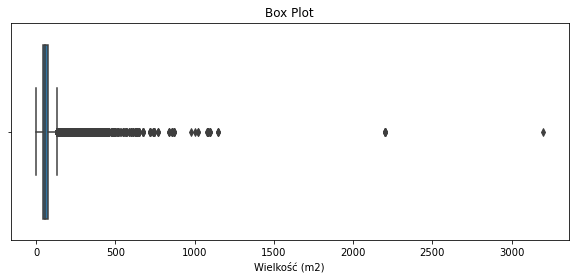

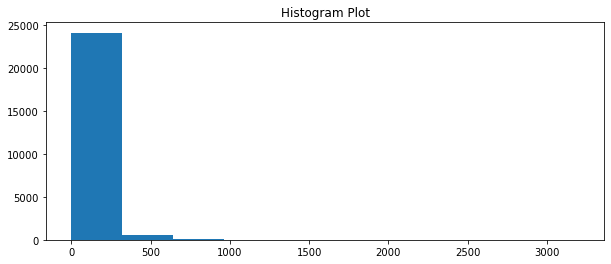

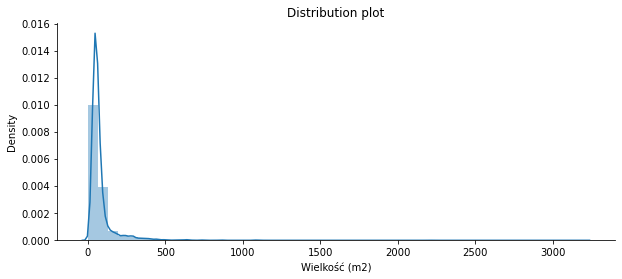

<Figure size 720x288 with 0 Axes>

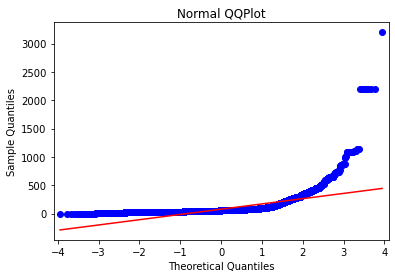

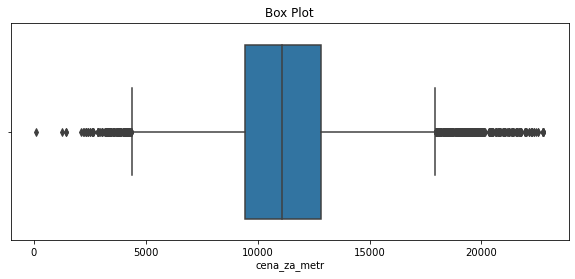

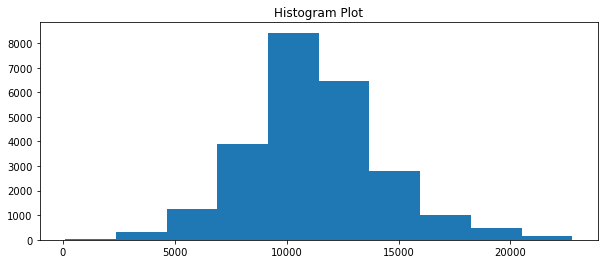

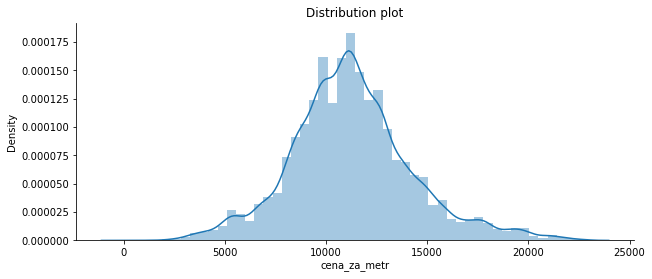

<Figure size 720x288 with 0 Axes>

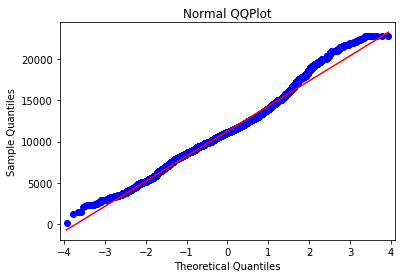

In [8]:
#Z-SCORE METHOD
with open("./data/clean_befoteEDA.pkl", "rb") as fh:
  data = pickle.load(fh)
print(len(Zscore_outlier(data['Wielkość (m2)'])))
print("Outliers:",Zscore_outlier(data['Wielkość (m2)']))
print("=========================================")
print(len(Zscore_outlier(data['cena_za_metr'])))
print("Outliers:",Zscore_outlier(data['cena_za_metr']))
data=data[~data['Wielkość (m2)'].isin(Zscore_outlier(data['Wielkość (m2)']))]
data=data[~data['cena_za_metr'].isin(Zscore_outlier(data['cena_za_metr']))]
test_data(data)
plot_wrapper(data['Wielkość (m2)'])
plot_wrapper(data['cena_za_metr'])


2019
Outliers: [390, 400, 200, 422, 338, 2200, 1082, 378, 450, 673, 330, 330, 291, 182, 280, 360, 161, 400, 182, 180, 445, 185, 179, 233, 230, 230, 200, 232, 232, 197, 180, 233, 188, 320, 202, 495, 340, 212, 290, 219, 290, 186, 9256, 350, 191, 207, 256, 260, 340, 200, 165, 166, 220, 438, 285, 183, 216, 1146, 1098, 280, 170, 235, 169, 400, 169, 360, 170, 288, 400, 189, 245, 205, 216, 190, 639, 310, 256, 340, 257, 327, 257, 170, 280, 270, 188, 182, 291, 180, 418, 182, 161, 400, 232, 179, 185, 233, 232, 230, 233, 230, 200, 180, 197, 170, 240, 538, 188, 182, 280, 182, 180, 161, 291, 200, 1082, 422, 378, 330, 360, 330, 673, 288, 390, 198, 2200, 400, 450, 338, 400, 205, 189, 216, 190, 629, 221, 639, 257, 240, 270, 367, 418, 200, 378, 1082, 422, 400, 220, 200, 270, 188, 161, 280, 182, 180, 182, 291, 244, 739, 230, 197, 230, 232, 233, 180, 232, 233, 200, 179, 185, 185, 170, 634, 180, 308, 270, 380, 270, 290, 200, 244, 250, 230, 170, 500, 180, 360, 208, 181, 838, 438, 342, 180, 380, 517, 169, 4

268
Outliers: [25666.666666666668, 24320.987654320987, 24117.647058823528, 24107.14285714286, 22758.064516129034, 23076.923076923078, 95531.91489361702, 23529.41176470588, 31142.85714285714, 23333.325, 23690.47619047619, 47500.0, 39774.436090225565, 44900.0, 37499.99375, 23690.47619047619, 72419.35483870968, 24117.647058823528, 25666.666666666668, 31764.70588235294, 24320.987654320987, 23076.923076923078, 24107.14285714286, 22758.064516129034, 24320.987654320987, 24117.647058823528, 22857.14285714286, 25666.666666666668, 31764.70588235294, 29729.72972972973, 24117.647058823528, 24320.987654320987, 22758.064516129034, 24107.14285714286, 23076.923076923078, 31411.764705882353, 31411.764705882353, 23541.666666666668, 25544.032882011605, 24416.666666666668, 24358.97435897436, 27472.527472527472, 25892.85714285714, 23000.0, 24257.14285714286, 22534.49090909091, 23937.5, 25814.814814814814, 24453.125, 37210.74534161491, 43985.82677165354, 28947.36842105263, 32000.0, 22962.925925925927, 27357

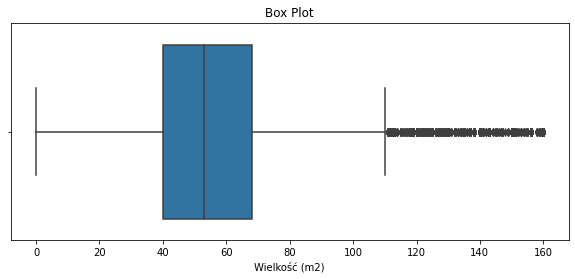

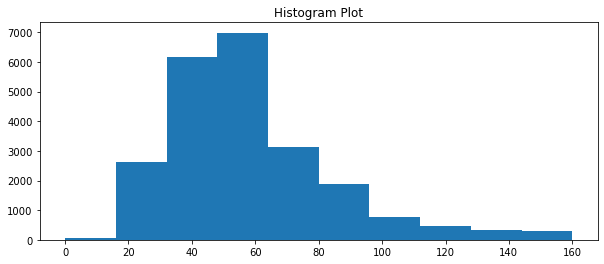

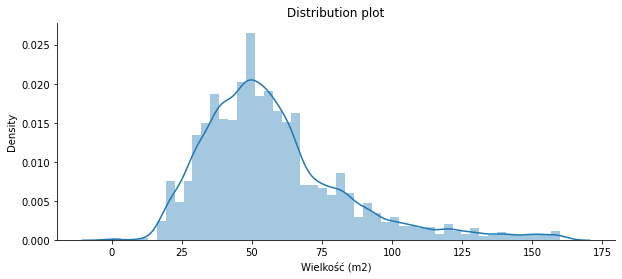

<Figure size 720x288 with 0 Axes>

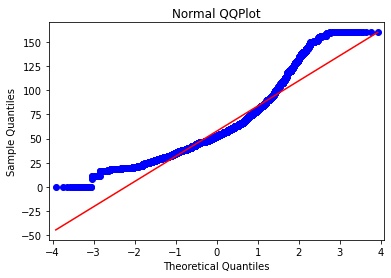

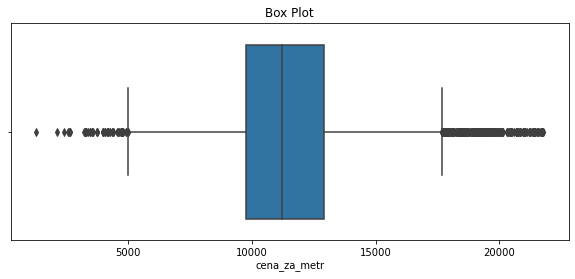

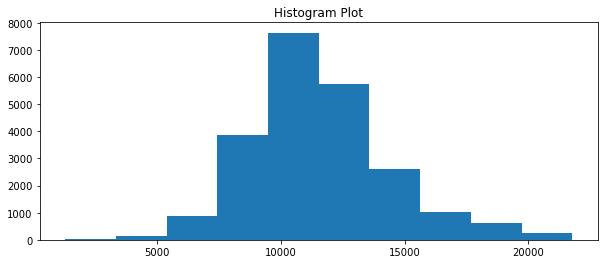

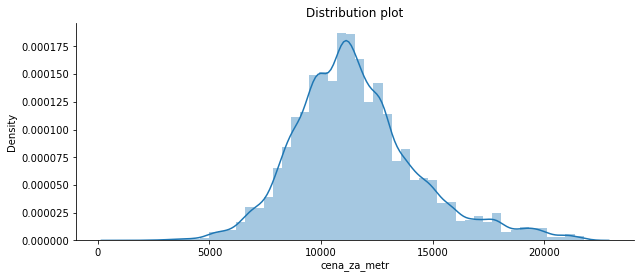

<Figure size 720x288 with 0 Axes>

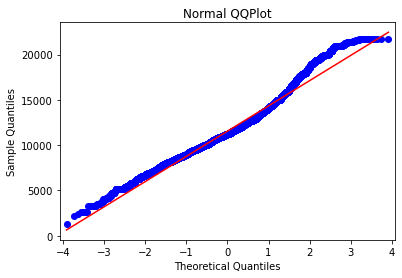

In [11]:
#ROBUST Z-SCORE
with open("./data/clean_befoteEDA.pkl", "rb") as fh:
  data = pickle.load(fh)

print(len(ZRscore_outlier(data['Wielkość (m2)'])))
print("Outliers:",ZRscore_outlier(data['Wielkość (m2)']))
print("=========================================")
print(len(ZRscore_outlier(data['cena_za_metr'])))
print("Outliers:",ZRscore_outlier(data['cena_za_metr']))
data=data[~data['Wielkość (m2)'].isin(ZRscore_outlier(data['Wielkość (m2)']))]
data=data[~data['cena_za_metr'].isin(ZRscore_outlier(data['cena_za_metr']))]
test_data(data)
plot_wrapper(data['Wielkość (m2)'])
plot_wrapper(data['cena_za_metr'])


2566
Outliers: [390, 400, 200, 422, 338, 2200, 1082, 378, 450, 673, 156, 141, 330, 330, 143, 160, 291, 182, 280, 135, 360, 161, 400, 182, 180, 445, 160, 185, 155, 140, 179, 150, 233, 230, 230, 138, 200, 232, 232, 197, 180, 233, 188, 320, 202, 495, 138, 340, 212, 290, 219, 290, 186, 9256, 350, 191, 207, 256, 260, 340, 200, 165, 166, 220, 133, 438, 285, 151, 154, 183, 140, 216, 1146, 1098, 280, 170, 137, 160, 235, 169, 400, 169, 360, 140, 170, 288, 400, 189, 245, 205, 160, 216, 151, 190, 639, 310, 256, 340, 257, 327, 257, 170, 280, 270, 188, 182, 291, 180, 418, 182, 161, 400, 133, 150, 232, 155, 179, 140, 185, 140, 233, 232, 230, 233, 230, 138, 200, 180, 197, 170, 160, 151, 240, 150, 538, 188, 182, 280, 182, 180, 161, 291, 200, 1082, 422, 378, 330, 143, 360, 330, 673, 288, 390, 198, 2200, 400, 450, 338, 400, 205, 189, 160, 216, 190, 151, 629, 221, 639, 257, 240, 270, 367, 156, 418, 200, 378, 1082, 422, 400, 220, 135, 155, 200, 155, 270, 188, 140, 161, 280, 182, 180, 182, 291, 244, 150, 7

[0.41441580208706796, 0.4040475951669693, 0.42102065120571, 0.4347576867181766, 0.4435594726031896]

Accuracy: 0.42 (+/- 0.03)
[3000711.9032261553, 2993980.1495898496, 3197217.200114976, 3178836.6348088016, 3283728.350251357]

Mean square error: 3130894.85 (+/- 229344.08)


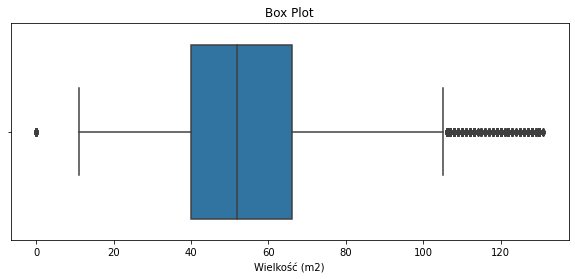

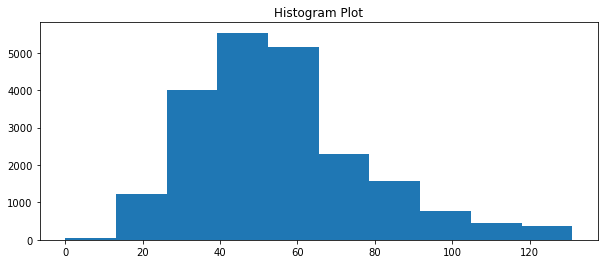

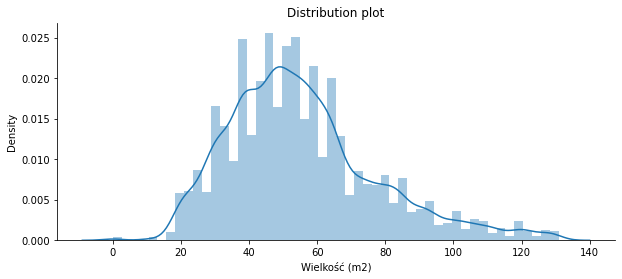

<Figure size 720x288 with 0 Axes>

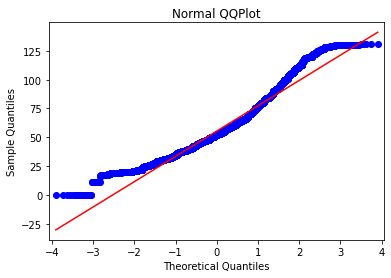

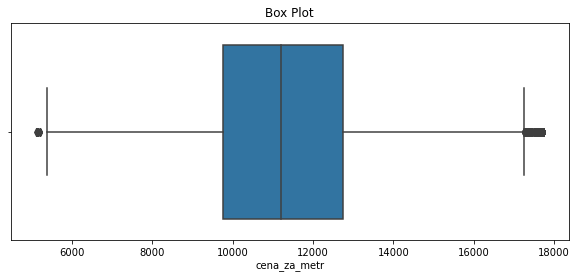

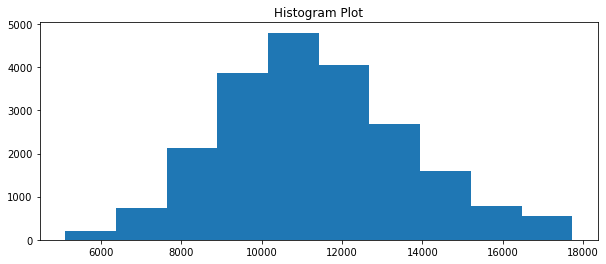

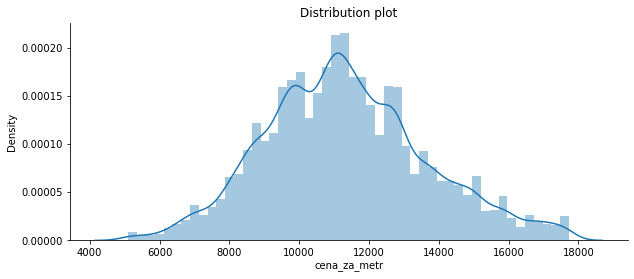

<Figure size 720x288 with 0 Axes>

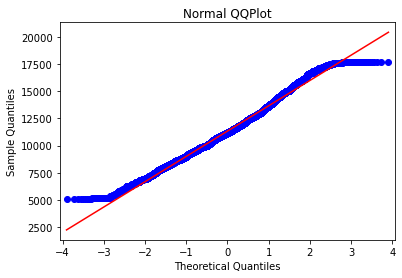

In [13]:
#IQR METHOD
with open("./data/clean_befoteEDA.pkl", "rb") as fh:
  data = pickle.load(fh)

print(len(iqr_outliers(data['Wielkość (m2)'])))
print("Outliers:",iqr_outliers(data['Wielkość (m2)']))
print("=========================================")
print(len(iqr_outliers(data['cena_za_metr'])))
print("Outliers:",iqr_outliers(data['cena_za_metr']))
data=data[~data['Wielkość (m2)'].isin(iqr_outliers(data['Wielkość (m2)']))]
data=data[~data['cena_za_metr'].isin(iqr_outliers(data['cena_za_metr']))]
test_data(data)
plot_wrapper(data['Wielkość (m2)'])
plot_wrapper(data['cena_za_metr'])

(25052, 16)
381
Outliers: [2200, 1082, 450, 673, 15, 17, 11, 11, 495, 17, 17, 17, 0, 9256, 18, 17, 1146, 1098, 18, 17, 11, 0, 639, 15, 0, 0, 11, 17, 11, 0, 538, 1082, 673, 2200, 450, 629, 639, 0, 15, 17, 11, 0, 1082, 0, 739, 634, 11, 17, 11, 500, 838, 517, 17, 768, 625, 460, 320000, 450, 650, 520, 1146, 485, 550, 477, 638, 450, 489, 610, 17, 741, 0, 480, 720, 497, 568, 515, 600, 450, 500, 860, 17, 870, 1020, 870, 450, 639, 16, 1098, 17, 18, 18, 17, 1082, 18, 629, 17, 15, 11, 0, 0, 673, 480, 450, 15, 450, 2200, 18, 17, 0, 0, 639, 600, 0, 600, 1080, 610, 15, 0, 15, 11, 17, 11, 568, 480, 515, 720, 497, 741, 600, 450, 650, 520, 860, 500, 450, 610, 638, 450, 477, 18, 15, 530, 17, 16, 0, 673, 2200, 977, 11, 15, 450, 450, 18, 700, 639, 450, 739, 517, 768, 625, 450, 18, 0, 500, 838, 17, 634, 460, 550, 489, 1020, 17, 11, 11, 450, 638, 610, 480, 741, 497, 568, 515, 720, 639, 11, 17, 11, 500, 860, 650, 520, 477, 638, 450, 610, 480, 741, 497, 568, 515, 720, 450, 600, 450, 17, 17, 485, 870, 870, 45

[0.4551367497002623, 0.4233772333443221, 0.45381718222821543, 0.44393936953481616, 0.43514586854218273]

Accuracy: 0.44 (+/- 0.02)
[4757705.116794049, 4723951.985828929, 4714612.213311922, 4768266.475877889, 4687211.17349007]

Mean square error: 4730349.39 (+/- 58893.34)


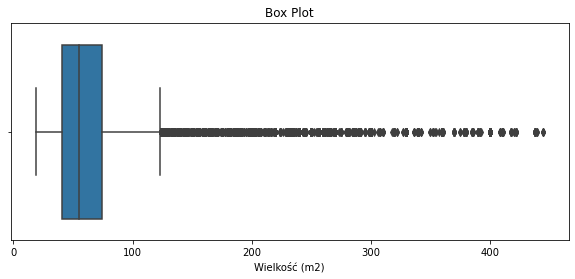

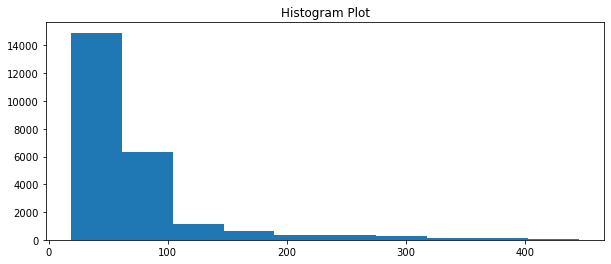

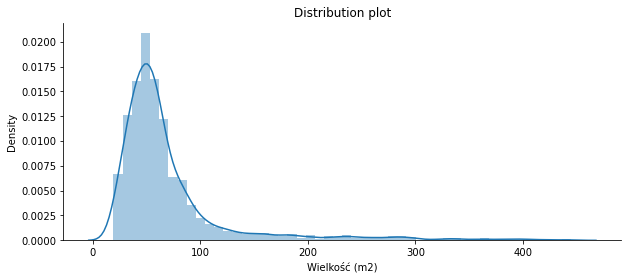

<Figure size 720x288 with 0 Axes>

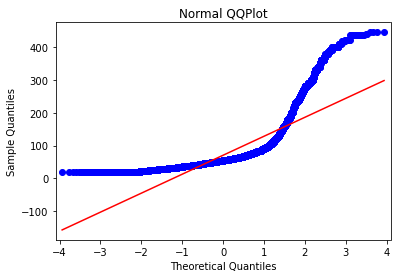

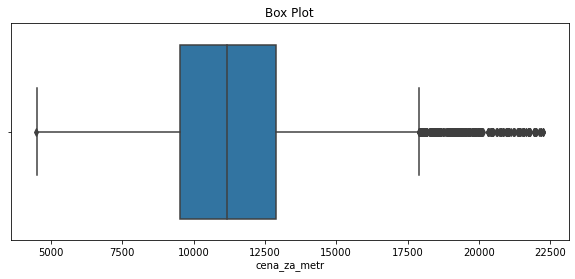

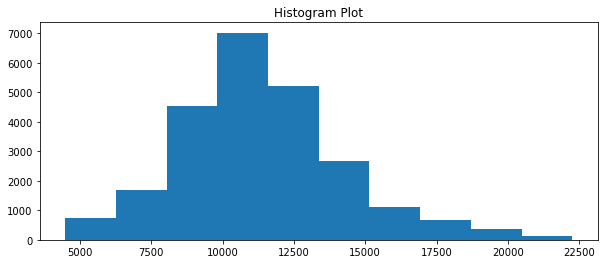

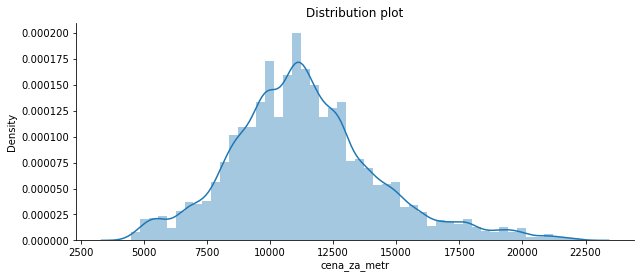

<Figure size 720x288 with 0 Axes>

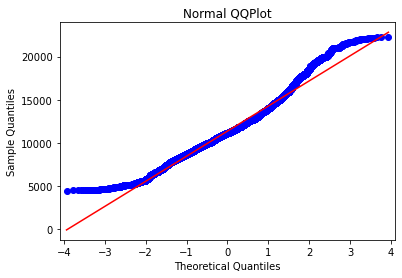

In [22]:
#WINSORIZATION METHOD(PERCENTILE CAPPING)

with open("./data/clean_befoteEDA.pkl", "rb") as fh:
  data = pickle.load(fh)
print(len(Winsorization_outliers(data['Wielkość (m2)'])))
print("Outliers:",Winsorization_outliers(data['Wielkość (m2)']))
print("=========================================")
print(len(Winsorization_outliers(data['cena_za_metr'])))
print("Outliers:",Winsorization_outliers(data['cena_za_metr']))
data=data[~data['Wielkość (m2)'].isin(Winsorization_outliers(data['Wielkość (m2)']))]
data=data[~data['cena_za_metr'].isin(Winsorization_outliers(data['cena_za_metr']))]
test_data(data)
plot_wrapper(data['Wielkość (m2)'])
plot_wrapper(data['cena_za_metr'])

### 1. Deleting observations.
### 2. Transforming values.
### 3. Imputation.
### 4. Separately treating

[0.4108319853527713, 0.43687689471510405, 0.41718871417324477, 0.430867299296549, 0.4294395890846626]

Accuracy: 0.43 (+/- 0.02)
[3200426.729713108, 3223659.986056603, 3432675.4785306347, 3279945.3476845254, 3327718.334266979]

Mean square error: 3292885.18 (+/- 165560.40)


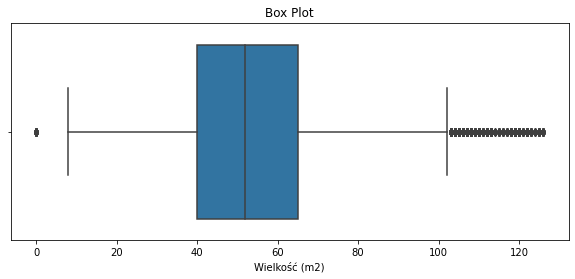

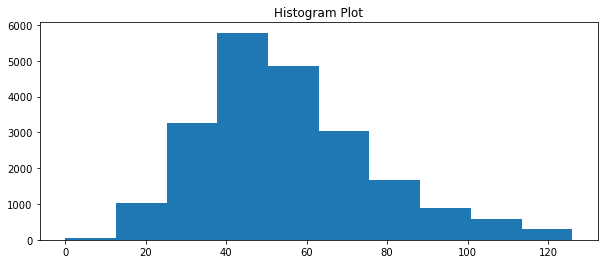

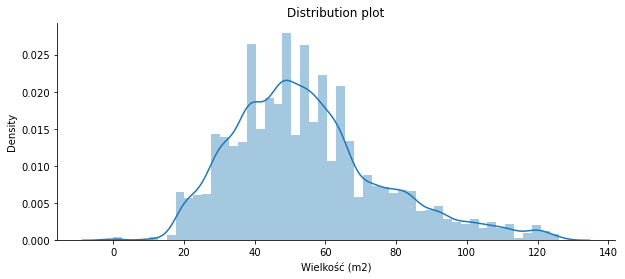

<Figure size 720x288 with 0 Axes>

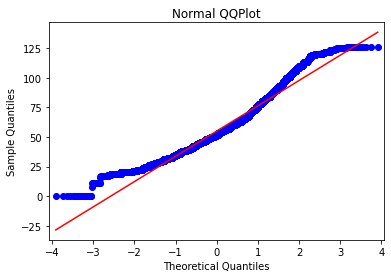

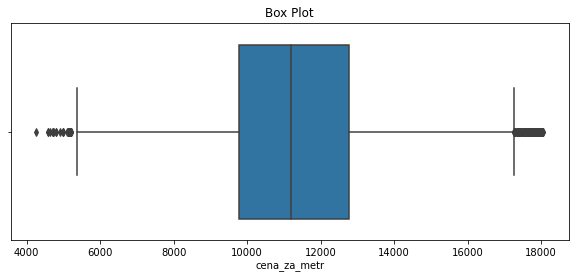

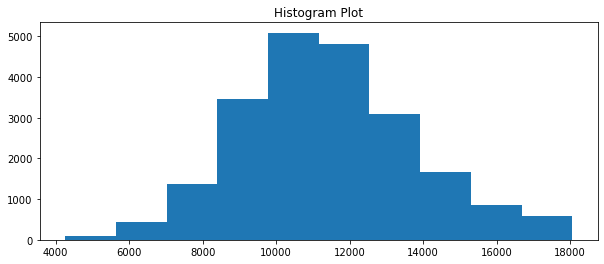

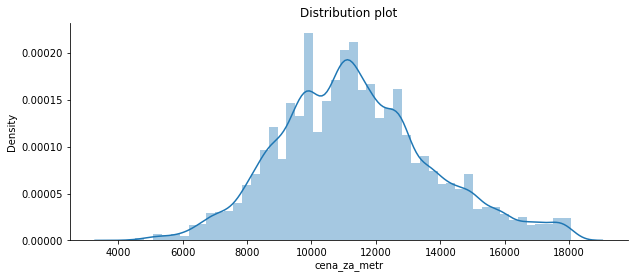

<Figure size 720x288 with 0 Axes>

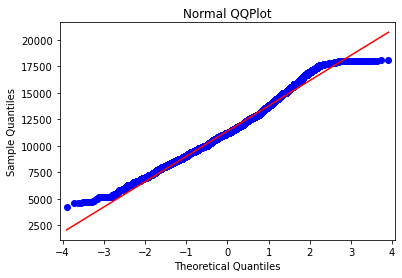

In [23]:
#1. Deleting observations
with open("./data/clean_befoteEDA.pkl", "rb") as fh:
  data = pickle.load(fh)
drop_outliers(data, 'cena_za_metr')
drop_outliers(data, 'Wielkość (m2)')
test_data(data)
plot_wrapper(data['Wielkość (m2)'])
plot_wrapper(data['cena_za_metr'])

# 2. Transforming values.
## 1. Scalling
## 2. Log transformation
## 3. Cube Root Normalization
## 4. Box-Cox transformation

[0.4066835875228675, 0.4040481672910643, 0.2873719427493625, 0.36742502746030015, 0.4197149707408663]

Accuracy: 0.38 (+/- 0.10)
[0.5272502037688869, 0.5151119187628228, 0.8814892878179501, 1.7942459531293053, 0.6287537658461034]

Mean square error: 0.87 (+/- 0.96)


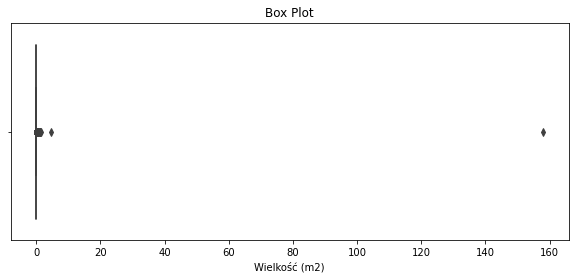

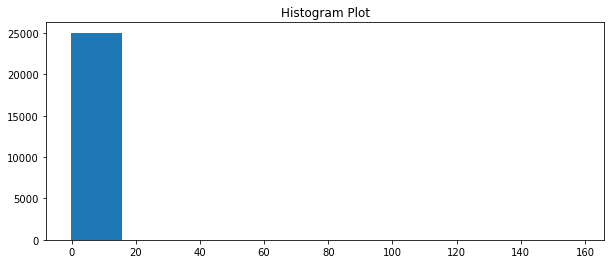

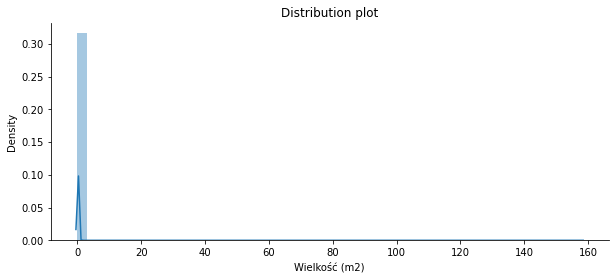

<Figure size 720x288 with 0 Axes>

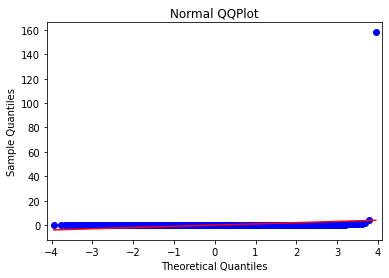

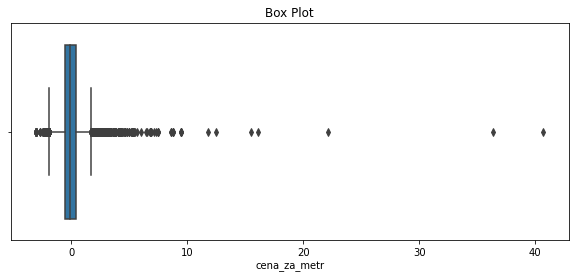

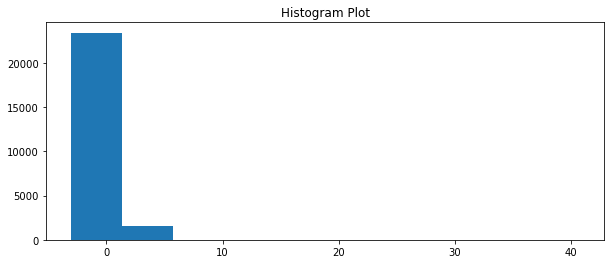

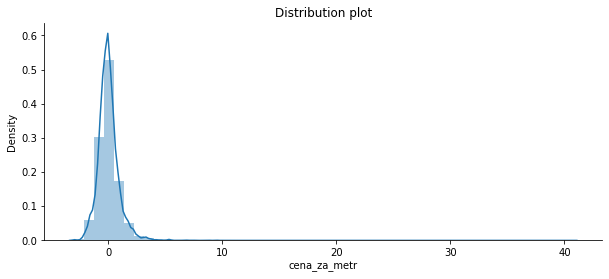

<Figure size 720x288 with 0 Axes>

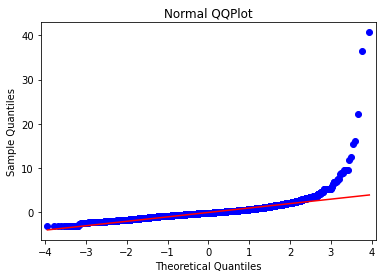

In [26]:
#Scalling

with open("./data/clean_befoteEDA.pkl", "rb") as fh:
  data = pickle.load(fh)
scaler = preprocessing.StandardScaler()
data['cena_za_metr'] = scaler.fit_transform(data['cena_za_metr'].values.reshape(-1,1))
data['Wielkość (m2)'] = scaler.fit_transform(data['Wielkość (m2)'].values.reshape(-1,1))
test_data(data)
plot_wrapper(data['Wielkość (m2)'])
plot_wrapper(data['cena_za_metr'])


In [34]:
#Log transformation
with open("./data/clean_befoteEDA.pkl", "rb") as fh:
  data = pickle.load(fh)

print(np.any(np.isinf(data['cena_za_metr'])))
print(data['cena_za_metr'].isnull().sum())
print(np.where(np.isnan(data['cena_za_metr'])))
# data['cena_za_metr']=np.log(data['cena_za_metr'])
# test_data(data)
# plot_wrapper(data['Wielkość (m2)'])
# plot_wrapper(data['cena_za_metr'])
data.describe()

False
0
(array([], dtype=int64),)


,Wielkość (m2),cena_za_metr,atrakcyjność,ekologia_ranking,bezpieczenstwo_ranking
count,25052.000000,25052.000000,25052.000000,25052.000000,25052.000000
mean,91.469903,11448.780401,0.483762,3.229863,3.796913
std,2024.213935,3794.377477,0.130418,0.287347,0.214181
min,0.000000,0.000000,0.134000,2.820000,3.450000
25%,41.000000,9454.545455,0.390000,2.970000,3.690000
50%,55.000000,11140.350877,0.462000,3.190000,3.750000
75%,77.000000,12895.833333,0.592000,3.500000,3.890000
max,320000.000000,165833.333333,0.704000,4.010000,4.280000


# Imputatation

MedianImputation
[0.4188770899597546, 0.42284836414755556, 0.44199380220129736, 0.41166332986950815, 0.4353097169984007]

Accuracy: 0.43 (+/- 0.02)
[3867760.699880772, 3819279.4647557186, 3691197.441468179, 3645394.736432774, 3703230.4066939983]

Mean square error: 3745372.55 (+/- 167684.36)


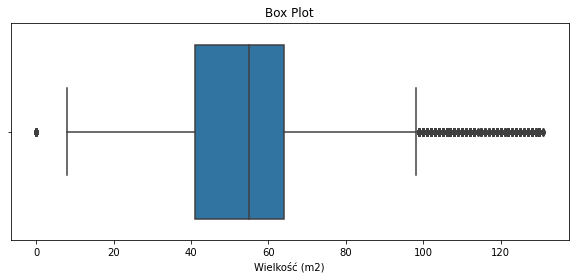

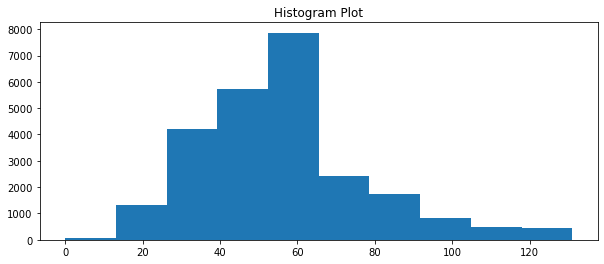

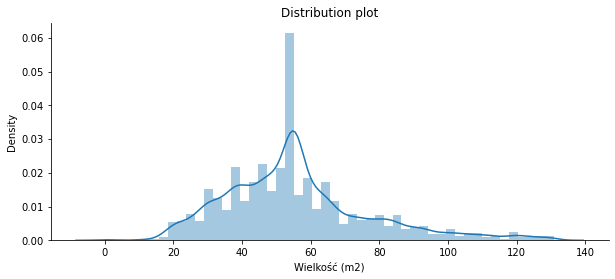

<Figure size 720x288 with 0 Axes>

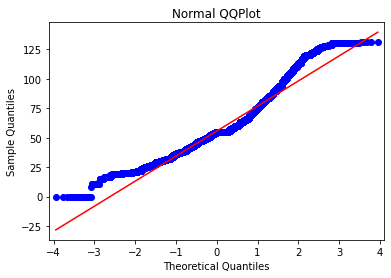

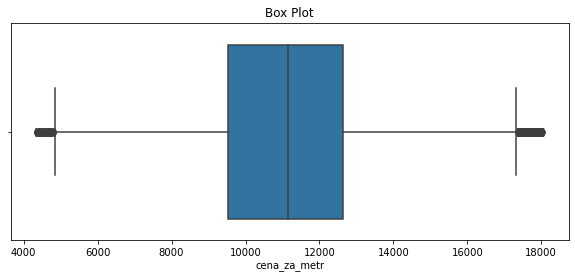

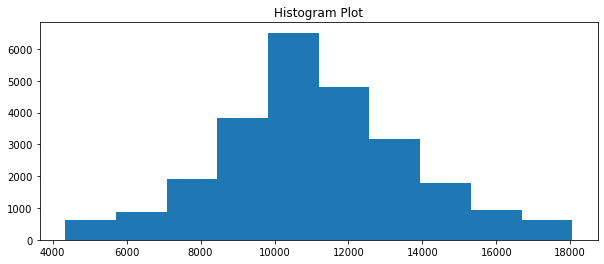

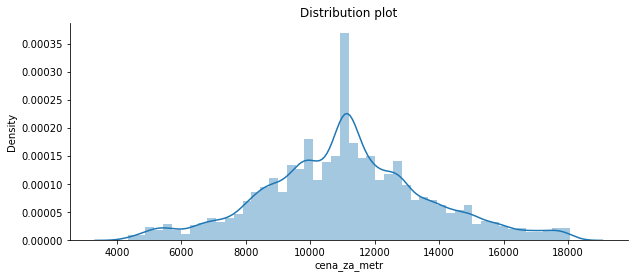

<Figure size 720x288 with 0 Axes>

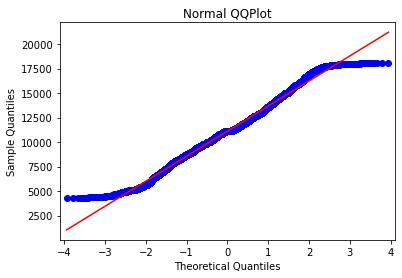

In [28]:
#median imputation
with open("./data/clean_befoteEDA.pkl", "rb") as fh:
  data = pickle.load(fh)

print("MedianImputation")
median_imputation(data,'cena_za_metr')
median_imputation(data,'Wielkość (m2)')
print("==================================================================")
test_data(data)
plot_wrapper(data['Wielkość (m2)'])
plot_wrapper(data['cena_za_metr'])


Before


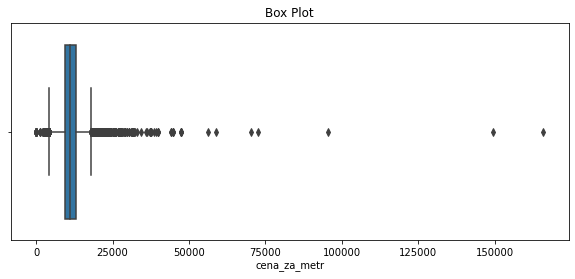

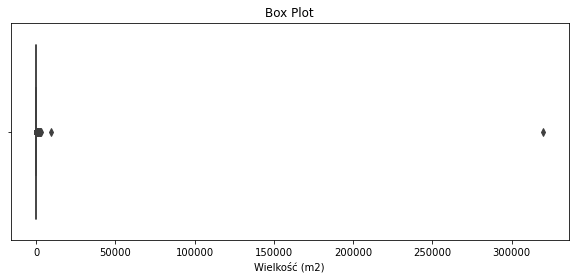

After
median_imputation_winsorization


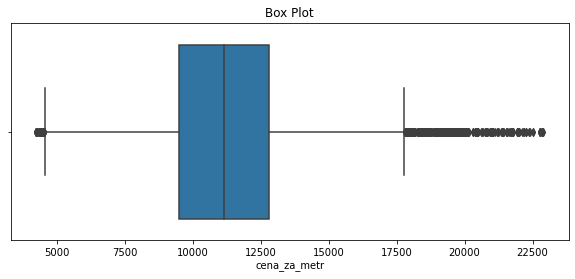

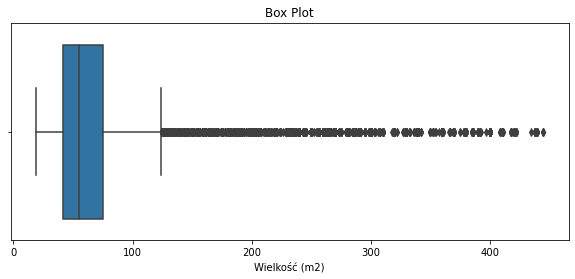

[0.4131778965656929, 0.42036635033236647, 0.4283920177117695, 0.39481042795772225, 0.4307395704678936]

Accuracy: 0.42 (+/- 0.03)
[5058980.671294206, 5151069.486805328, 4961391.167784971, 5024149.3068010155, 4841853.736341282]

Mean square error: 5007488.87 (+/- 206115.24)


In [20]:
#median_imputation_winsorization
with open("./data/clean_befoteEDA.pkl", "rb") as fh:
  data = pickle.load(fh)
print("median_imputation_winsorization")
median_imputation_winsorization(data,'cena_za_metr')
median_imputation_winsorization(data,'Wielkość (m2)')
print("==================================================================")
test_data(data)
plot_wrapper(data['Wielkość (m2)'])
plot_wrapper(data['cena_za_metr'])




median_imputation_robust_zscore
Dataset is clean
[0.4364421174460441, 0.4405656808276772, 0.45467156873602876, 0.41550940859322116, 0.45733589772892824]

Accuracy: 0.44 (+/- 0.03)
[5178613.182755756, 5165722.215469519, 4998973.260538504, 5186861.595763756, 4931725.426888707]

Mean square error: 5092379.14 (+/- 212182.42)


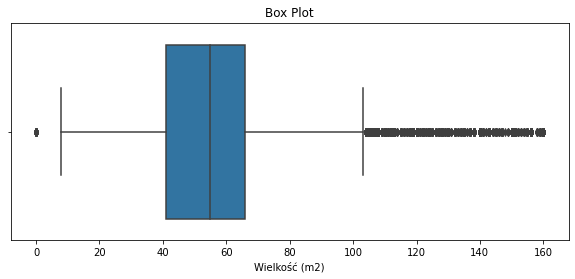

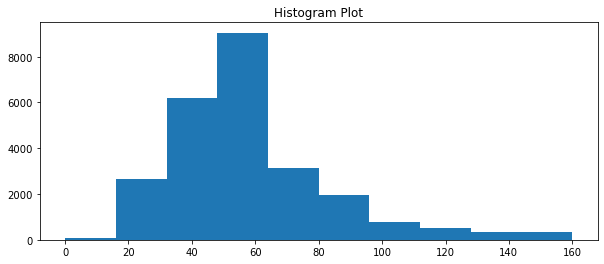

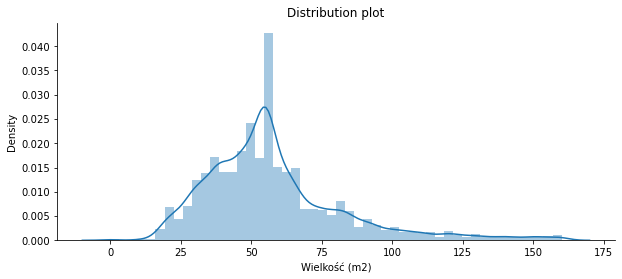

<Figure size 720x288 with 0 Axes>

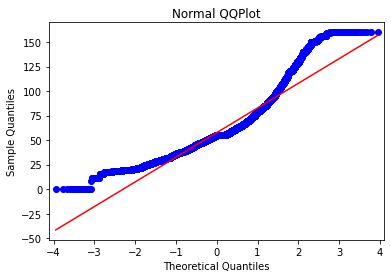

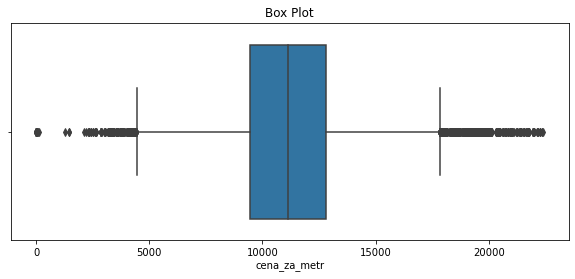

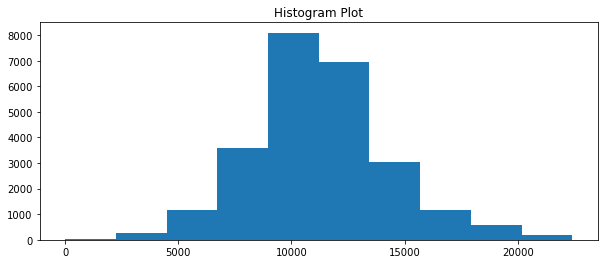

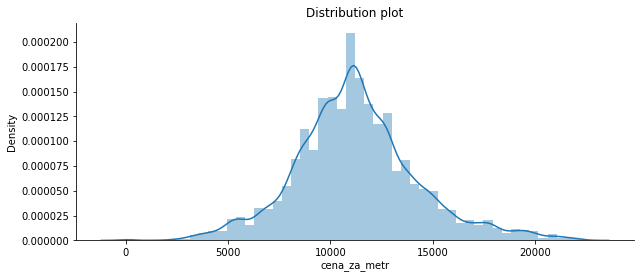

<Figure size 720x288 with 0 Axes>

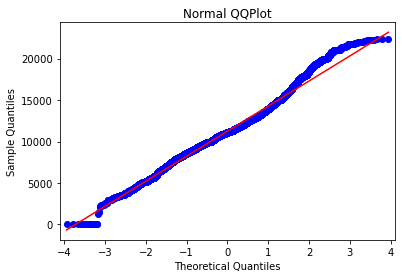

In [95]:
#median imputation with  ROBUST Z-SCORE
with open("./data/clean_befoteEDA.pkl", "rb") as fh:
  data = pickle.load(fh)
print("median_imputation_robust_zscore")
median_imputation_robust_zscore(data,'cena_za_metr')
median_imputation_robust_zscore(data,'Wielkość (m2)')
print("==================================================================")
# data['cena_za_metr'] = scaler.fit_transform(data['cena_za_metr'].values.reshape(-1,1))
# data['Wielkość (m2)'] = scaler.fit_transform(data['Wielkość (m2)'].values.reshape(-1,1))
#data['cena_za_metr']=data['cena_za_metr'].progress_apply(lambda x: np.log(x))
check_inf_nan(data,'cena_za_metr')
test_data(data)
plot_wrapper(data['Wielkość (m2)'])
plot_wrapper(data['cena_za_metr'])